In [11]:
import gensim
import pandas as pd
import keras
import pickle
import numpy as np

C:\Users\Dellpc\Anaconda2\envs\myenv\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [12]:
filename='preprocessed_data.pkl'

In [13]:
data=pickle.load(open(filename,'rb')) ###open preprocessed data

In [14]:
len(data)

3243

In [15]:
data.head()

,Transcript,AD
0,um young boy getting cookie jar,1
1,and it uh bad shape uh thing,1
2,and picture mother washing dish and see it,1
3,and dish might get falled,1
4,fell fall get it,1


In [16]:
Y= data.iloc[:,1].values
Y

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [17]:
###Manually resolve the tabbed data errors

index = [791,  792,  793,  830,  831,  832,  833,  839,  844, 846, 852,  853,
         855,  858,  860,  876,  882,  890,  892,  904,  909,  912,  936,
         938,  943,  945,  957,  964,  965,  967,  969,  972,  975,  976,
        1000, 1007, 1013, 1018, 1297] 
for i in index:
    Y[i] = 0  ###replace value of selected indices of AD column with 0

idx = [1072, 1101, 1184, 1244]
for i in idx:
    Y[i] = 1  ###replace value of selected indices of AD column with 1
Y = Y.astype(int)

In [18]:
X = data['Transcript'].tolist()

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 0) ##split the data in training and testing

In [21]:
print(len(X_train)) ###length of training, testing data
print(len(X_test))
print(len(Y_train))
print(len(Y_test))

2594
649
2594
649


In [22]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [23]:
def create_tokens(lines):
    tokens = Tokenizer()        ###function to create tokens
    tokens.fit_on_texts(lines)
    return tokens

In [24]:
train_tokenizer = create_tokens(X_train)

In [25]:
def encode_sentences(tokens,length,lines):   ###function to pad the data to maximum phrase length
    X=tokens.texts_to_sequences(lines)
    X=pad_sequences(X,length,padding='post')
    return X    

In [26]:
X_train = encode_sentences(train_tokenizer,100, X_train)
X_test = encode_sentences(train_tokenizer,100, X_test)

In [27]:
print(X_train.shape)   ###check for dimensions
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(2594, 100)
(649, 100)
(2594,)
(649,)


In [28]:
vocab_len= len(train_tokenizer.word_index ) + 1 
vocab_len   ###vocab length

847

# CNN MODEL - Case 1: Training the model using randomly initialized embedding

In [8]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dense 
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.constraints import maxnorm

Using TensorFlow backend.


# BASIC CNN MODEL

In [205]:
model = Sequential()
e = Embedding(vocab_len, 100, input_length= 100)
model.add(e)
model.add(Conv1D(filters=128,kernel_size=3,activation='relu',strides= 1, kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units =256, activation= 'relu',kernel_initializer='he_uniform', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))
model.compile(optimizer='RMSprop', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [207]:
cnn_history=model.fit(X_train, Y_train, epochs = 25, batch_size = 128, verbose = 1, validation_split = 0.1)

Train on 2334 samples, validate on 260 samples
Epoch 1/25
2334/2334 [==============================] - 40s 17ms/step - loss: 0.6905 - acc: 0.5484 - val_loss: 0.6713 - val_acc: 0.5923
Epoch 2/25


C:\Users\Dellpc\Anaconda2\envs\myenv\lib\site-packages\keras\callbacks.py:434: RuntimeWarning: Can save best model only with val_accuracy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


2334/2334 [==============================] - 39s 17ms/step - loss: 0.6104 - acc: 0.6829 - val_loss: 0.5855 - val_acc: 0.7192
Epoch 3/25
2334/2334 [==============================] - 40s 17ms/step - loss: 0.4862 - acc: 0.7755 - val_loss: 0.5078 - val_acc: 0.7385
Epoch 4/25
2334/2334 [==============================] - 39s 17ms/step - loss: 0.3761 - acc: 0.8329 - val_loss: 0.4818 - val_acc: 0.7692
Epoch 5/25
2334/2334 [==============================] - 39s 17ms/step - loss: 0.3177 - acc: 0.8663 - val_loss: 0.5470 - val_acc: 0.7692
Epoch 6/25
2334/2334 [==============================] - 39s 17ms/step - loss: 0.2697 - acc: 0.8882 - val_loss: 0.4832 - val_acc: 0.8115
Epoch 7/25
2334/2334 [==============================] - 39s 17ms/step - loss: 0.2327 - acc: 0.9002 - val_loss: 0.4284 - val_acc: 0.8115
Epoch 8/25
2334/2334 [==============================] - 39s 17ms/step - loss: 0.2087 - acc: 0.9100 - val_loss: 0.4373 - val_acc: 0.8077
Epoch 9/25
2334/2334 [==============================] - 40s

In [208]:
score = model.evaluate(X_test,Y_test,verbose = 1)

649/649 [==============================] - 0s 143us/step


In [229]:
print('Accuracy of the model is {}'.format(score[1]))

Accuracy of the model is 0.8489984593516322


# Hyperparameter tuning

In [241]:
def model_cnn_create(neurons = 128, optimizer = 'Adam',
                 dropout_rate = 0.2, weight_constraint = 3, nb_filters = 256, kernel_size = 5):
    
    model = Sequential()
    model.add(Embedding(input_dim = vocab_len, output_dim = 100, input_length = 100))
    model.add(Conv1D(nb_filters, kernel_size, activation = 'relu',strides = 1, kernel_initializer= 'he_uniform'))   
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(units = neurons, kernel_constraint=maxnorm(weight_constraint),kernel_initializer= 'he_uniform', activation = 'relu'))
    model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))   
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [240]:
param_grid = {
    'optimizer': ['RMSprop','Adam','SGD'],

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

C:\Users\Dellpc\Anaconda2\envs\myenv\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] optimizer=RMSprop ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
 - 59s - loss: 0.6991 - acc: 0.5315
Epoch 2/10
 - 38s - loss: 0.5782 - acc: 0.6929
Epoch 3/10
 - 38s - loss: 0.4312 - acc: 0.8074
Epoch 4/10
 - 38s - loss: 0.3392 - acc: 0.8485
Epoch 5/10
 - 38s - loss: 0.2688 - acc: 0.8884
Epoch 6/10
 - 39s - loss: 0.2088 - acc: 0.9121
Epoch 7/10
 - 39s - loss: 0.1823 - acc: 0.9260
Epoch 8/10
 - 38s - loss: 0.1594 - acc: 0.9335
Epoch 9/10
 - 38s - loss: 0.1312 - acc: 0.9485
Epoch 10/10
 - 39s - loss: 0.1340 - acc: 0.9485
[CV] ................................ optimizer=RMSprop, total= 7.1min
[CV] optimizer=RMSprop ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.1min remaining:    0.0s


Epoch 1/10
 - 62s - loss: 0.6994 - acc: 0.5200
Epoch 2/10
 - 37s - loss: 0.5724 - acc: 0.7021
Epoch 3/10
 - 37s - loss: 0.4263 - acc: 0.8022
Epoch 4/10
 - 38s - loss: 0.3231 - acc: 0.8554
Epoch 5/10
 - 38s - loss: 0.2544 - acc: 0.8924
Epoch 6/10
 - 38s - loss: 0.2185 - acc: 0.9098
Epoch 7/10
 - 38s - loss: 0.1899 - acc: 0.9156
Epoch 8/10
 - 38s - loss: 0.1631 - acc: 0.9364
Epoch 9/10
 - 38s - loss: 0.1491 - acc: 0.9445
Epoch 10/10
 - 38s - loss: 0.1260 - acc: 0.9503
[CV] ................................ optimizer=RMSprop, total= 7.2min
[CV] optimizer=RMSprop ...............................................
Epoch 1/10
 - 62s - loss: 0.7145 - acc: 0.5387
Epoch 2/10
 - 38s - loss: 0.5822 - acc: 0.6873
Epoch 3/10
 - 38s - loss: 0.4410 - acc: 0.7873
Epoch 4/10
 - 38s - loss: 0.3483 - acc: 0.8474
Epoch 5/10
 - 37s - loss: 0.2682 - acc: 0.8873
Epoch 6/10
 - 38s - loss: 0.2286 - acc: 0.9012
Epoch 7/10
 - 38s - loss: 0.1989 - acc: 0.9156
Epoch 8/10
 - 38s - loss: 0.1723 - acc: 0.9254
Epoch 9/10


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 63.3min finished


Epoch 1/10
 - 78s - loss: 0.6784 - acc: 0.5671
Epoch 2/10
 - 56s - loss: 0.5153 - acc: 0.7475
Epoch 3/10
 - 57s - loss: 0.3295 - acc: 0.8485
Epoch 4/10
 - 57s - loss: 0.2320 - acc: 0.8975
Epoch 5/10
 - 56s - loss: 0.1937 - acc: 0.9121
Epoch 6/10
 - 57s - loss: 0.1761 - acc: 0.9221
Epoch 7/10
 - 56s - loss: 0.1431 - acc: 0.9441
Epoch 8/10
 - 57s - loss: 0.1340 - acc: 0.9449
Epoch 9/10
 - 56s - loss: 0.1237 - acc: 0.9449
Epoch 10/10
 - 56s - loss: 0.1254 - acc: 0.9426
Best accuracy:  0.80763299922899
Best parameters:  {'optimizer': 'Adam'}


In [242]:
  param_grid = {
    'dropout_rate':[0.1,0.2,0.3,0.4,0.5],
    'weight_constraint':[1,2,3,4,5],

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

C:\Users\Dellpc\Anaconda2\envs\myenv\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] dropout_rate=0.1, weight_constraint=1 ...........................
Epoch 1/10
 - 86s - loss: 0.6887 - acc: 0.5506
Epoch 2/10
 - 40s - loss: 0.5843 - acc: 0.6912
Epoch 3/10
 - 40s - loss: 0.3952 - acc: 0.8224
Epoch 4/10
 - 41s - loss: 0.2722 - acc: 0.8890
Epoch 5/10
 - 40s - loss: 0.2114 - acc: 0.9173
Epoch 6/10
 - 39s - loss: 0.1703 - acc: 0.9346
Epoch 7/10
 - 41s - loss: 0.1357 - acc: 0.9456
Epoch 8/10
 - 41s - loss: 0.1327 - acc: 0.9485
Epoch 9/10
 - 40s - loss: 0.1144 - acc: 0.9532
Epoch 10/10
 - 40s - loss: 0.1344 - acc: 0.9462
[CV] ............ dropout_rate=0.1, weight_constraint=1, total= 8.2min
[CV] dropout_rate=0.1, weight_constraint=1 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.2min remaining:    0.0s


Epoch 1/10
 - 740s - loss: 0.6929 - acc: 0.5281
Epoch 2/10
 - 37s - loss: 0.6260 - acc: 0.6466
Epoch 3/10
 - 39s - loss: 0.4363 - acc: 0.7958
Epoch 4/10
 - 39s - loss: 0.3175 - acc: 0.8571
Epoch 5/10
 - 40s - loss: 0.2383 - acc: 0.8971
Epoch 6/10
 - 39s - loss: 0.1966 - acc: 0.9213
Epoch 7/10
 - 38s - loss: 0.2128 - acc: 0.9086
Epoch 8/10
 - 38s - loss: 0.1653 - acc: 0.9358
Epoch 9/10
 - 38s - loss: 0.1406 - acc: 0.9427
Epoch 10/10
 - 38s - loss: 0.1358 - acc: 0.9456
[CV] ............ dropout_rate=0.1, weight_constraint=1, total=42.7min
[CV] dropout_rate=0.1, weight_constraint=1 ...........................
Epoch 1/10
 - 110s - loss: 0.6813 - acc: 0.5468
Epoch 2/10
 - 38s - loss: 0.5472 - acc: 0.7121
Epoch 3/10
 - 38s - loss: 0.3506 - acc: 0.8474
Epoch 4/10
 - 38s - loss: 0.2356 - acc: 0.9000
Epoch 5/10
 - 38s - loss: 0.1909 - acc: 0.9231
Epoch 6/10
 - 38s - loss: 0.1550 - acc: 0.9329
Epoch 7/10
 - 38s - loss: 0.1537 - acc: 0.9353
Epoch 8/10
 - 38s - loss: 0.1270 - acc: 0.9416
Epoch 9/1

Epoch 6/10
 - 38s - loss: 0.1612 - acc: 0.9301
Epoch 7/10
 - 38s - loss: 0.1467 - acc: 0.9393
Epoch 8/10
 - 38s - loss: 0.1300 - acc: 0.9439
Epoch 9/10
 - 38s - loss: 0.1244 - acc: 0.9451
Epoch 10/10
 - 37s - loss: 0.1126 - acc: 0.9474
[CV] ............ dropout_rate=0.1, weight_constraint=5, total= 7.5min
[CV] dropout_rate=0.2, weight_constraint=1 ...........................
Epoch 1/10
 - 74s - loss: 0.6852 - acc: 0.5414
Epoch 2/10
 - 38s - loss: 0.5642 - acc: 0.7126
Epoch 3/10
 - 37s - loss: 0.3726 - acc: 0.8300
Epoch 4/10
 - 38s - loss: 0.2700 - acc: 0.8837
Epoch 5/10
 - 38s - loss: 0.2033 - acc: 0.9248
Epoch 6/10
 - 37s - loss: 0.2123 - acc: 0.9156
Epoch 7/10
 - 39s - loss: 0.1552 - acc: 0.9375
Epoch 8/10
 - 38s - loss: 0.1302 - acc: 0.9456
Epoch 9/10
 - 37s - loss: 0.1191 - acc: 0.9497
Epoch 10/10
 - 37s - loss: 0.1146 - acc: 0.9532
[CV] ............ dropout_rate=0.2, weight_constraint=1, total= 7.7min
[CV] dropout_rate=0.2, weight_constraint=1 ...........................
Epoch 1/1

[CV] ............ dropout_rate=0.2, weight_constraint=5, total= 7.4min
[CV] dropout_rate=0.2, weight_constraint=5 ...........................
Epoch 1/10
 - 66s - loss: 0.6924 - acc: 0.5396
Epoch 2/10
 - 38s - loss: 0.5700 - acc: 0.7056
Epoch 3/10
 - 37s - loss: 0.3585 - acc: 0.8409
Epoch 4/10
 - 39s - loss: 0.2435 - acc: 0.9028
Epoch 5/10
 - 38s - loss: 0.2043 - acc: 0.9115
Epoch 6/10
 - 38s - loss: 0.1530 - acc: 0.9410
Epoch 7/10
 - 38s - loss: 0.1310 - acc: 0.9462
Epoch 8/10
 - 38s - loss: 0.1209 - acc: 0.9497
Epoch 9/10
 - 38s - loss: 0.1114 - acc: 0.9537
Epoch 10/10
 - 38s - loss: 0.1106 - acc: 0.9514
[CV] ............ dropout_rate=0.2, weight_constraint=5, total= 7.5min
[CV] dropout_rate=0.2, weight_constraint=5 ...........................
Epoch 1/10
 - 72s - loss: 0.6875 - acc: 0.5445
Epoch 2/10
 - 39s - loss: 0.6120 - acc: 0.6775
Epoch 3/10
 - 39s - loss: 0.4360 - acc: 0.7960
Epoch 4/10
 - 39s - loss: 0.3180 - acc: 0.8543
Epoch 5/10
 - 39s - loss: 0.2243 - acc: 0.9052
Epoch 6/10

Epoch 3/10
 - 39s - loss: 0.3933 - acc: 0.8197
Epoch 4/10
 - 40s - loss: 0.2689 - acc: 0.8844
Epoch 5/10
 - 40s - loss: 0.1991 - acc: 0.9179
Epoch 6/10
 - 39s - loss: 0.1648 - acc: 0.9312
Epoch 7/10
 - 40s - loss: 0.1382 - acc: 0.9358
Epoch 8/10
 - 40s - loss: 0.1230 - acc: 0.9422
Epoch 9/10
 - 40s - loss: 0.1192 - acc: 0.9468
Epoch 10/10
 - 39s - loss: 0.1094 - acc: 0.9514
[CV] ............ dropout_rate=0.3, weight_constraint=4, total= 7.5min
[CV] dropout_rate=0.3, weight_constraint=5 ...........................
Epoch 1/10
 - 67s - loss: 0.6874 - acc: 0.5489
Epoch 2/10
 - 39s - loss: 0.5760 - acc: 0.7004
Epoch 3/10
 - 39s - loss: 0.3866 - acc: 0.8201
Epoch 4/10
 - 39s - loss: 0.2591 - acc: 0.8959
Epoch 5/10
 - 39s - loss: 0.2183 - acc: 0.9098
Epoch 6/10
 - 40s - loss: 0.1701 - acc: 0.9352
Epoch 7/10
 - 39s - loss: 0.1408 - acc: 0.9433
Epoch 8/10
 - 40s - loss: 0.1260 - acc: 0.9503
Epoch 9/10
 - 40s - loss: 0.1437 - acc: 0.9381
Epoch 10/10
 - 39s - loss: 0.1109 - acc: 0.9537
[CV] .....

Epoch 8/10
 - 39s - loss: 0.1073 - acc: 0.9560
Epoch 9/10
 - 39s - loss: 0.1139 - acc: 0.9537
Epoch 10/10
 - 40s - loss: 0.1012 - acc: 0.9607
[CV] ............ dropout_rate=0.4, weight_constraint=4, total= 7.4min
[CV] dropout_rate=0.4, weight_constraint=4 ...........................
Epoch 1/10
 - 70s - loss: 0.6949 - acc: 0.5321
Epoch 2/10
 - 39s - loss: 0.5775 - acc: 0.7085
Epoch 3/10
 - 39s - loss: 0.3482 - acc: 0.8444
Epoch 4/10
 - 39s - loss: 0.2309 - acc: 0.9017
Epoch 5/10
 - 40s - loss: 0.1688 - acc: 0.9329
Epoch 6/10
 - 39s - loss: 0.1504 - acc: 0.9329
Epoch 7/10
 - 40s - loss: 0.1249 - acc: 0.9508
Epoch 8/10
 - 40s - loss: 0.1148 - acc: 0.9503
Epoch 9/10
 - 40s - loss: 0.1106 - acc: 0.9503
Epoch 10/10
 - 39s - loss: 0.0968 - acc: 0.9526
[CV] ............ dropout_rate=0.4, weight_constraint=4, total= 7.5min
[CV] dropout_rate=0.4, weight_constraint=4 ...........................
Epoch 1/10
 - 71s - loss: 0.6914 - acc: 0.5503
Epoch 2/10
 - 40s - loss: 0.5624 - acc: 0.7087
Epoch 3/1

Epoch 1/10
 - 87s - loss: 0.6852 - acc: 0.5468
Epoch 2/10
 - 40s - loss: 0.5893 - acc: 0.6838
Epoch 3/10
 - 43s - loss: 0.4038 - acc: 0.8225
Epoch 4/10
 - 42s - loss: 0.2669 - acc: 0.8873
Epoch 5/10
 - 41s - loss: 0.2017 - acc: 0.9139
Epoch 6/10
 - 40s - loss: 0.1929 - acc: 0.9162
Epoch 7/10
 - 40s - loss: 0.1468 - acc: 0.9416
Epoch 8/10
 - 42s - loss: 0.1313 - acc: 0.9410
Epoch 9/10
 - 43s - loss: 0.1199 - acc: 0.9462
Epoch 10/10
 - 42s - loss: 0.1128 - acc: 0.9491
[CV] ............ dropout_rate=0.5, weight_constraint=3, total= 9.0min
[CV] dropout_rate=0.5, weight_constraint=4 ...........................
Epoch 1/10
 - 90s - loss: 0.6858 - acc: 0.5419
Epoch 2/10
 - 41s - loss: 0.5569 - acc: 0.7143
Epoch 3/10
 - 40s - loss: 0.3457 - acc: 0.8548
Epoch 4/10
 - 40s - loss: 0.2745 - acc: 0.8826
Epoch 5/10
 - 38s - loss: 0.1781 - acc: 0.9306
Epoch 6/10
 - 39s - loss: 0.1500 - acc: 0.9416
Epoch 7/10
 - 38s - loss: 0.1310 - acc: 0.9520
Epoch 8/10
 - 38s - loss: 0.1094 - acc: 0.9532
Epoch 9/10


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 656.7min finished


Epoch 1/10
 - 95s - loss: 0.6670 - acc: 0.5725
Epoch 2/10
 - 61s - loss: 0.4569 - acc: 0.7841
Epoch 3/10
 - 62s - loss: 0.2816 - acc: 0.8797
Epoch 4/10
 - 62s - loss: 0.1974 - acc: 0.9148
Epoch 5/10
 - 61s - loss: 0.1688 - acc: 0.9260
Epoch 6/10
 - 58s - loss: 0.1499 - acc: 0.9406
Epoch 7/10
 - 57s - loss: 0.1258 - acc: 0.9445
Epoch 8/10
 - 57s - loss: 0.1194 - acc: 0.9503
Epoch 9/10
 - 58s - loss: 0.1117 - acc: 0.9537
Epoch 10/10
 - 58s - loss: 0.1069 - acc: 0.9499
Best accuracy:  0.7995373939861218
Best parameters:  {'dropout_rate': 0.5, 'weight_constraint': 4}


# CNN MODEL WITH OPTIMISED PARAMETERS

In [93]:
model = Sequential()
e = Embedding(vocab_len, 100, input_length= 100)
model.add(e)
model.add(Conv1D(filters=256,kernel_size=5,activation='relu',strides= 1, kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units =128, activation= 'relu',kernel_initializer='he_uniform', kernel_constraint=maxnorm(4)))
model.add(Dropout(0.5))
model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))
model.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [38]:
cnn_history=model.fit(X_train, Y_train, epochs = 25, batch_size = 128, verbose = 1, validation_split = 0.1)

Train on 2334 samples, validate on 260 samples
Epoch 1/25
2334/2334 [==============================] - 42s 18ms/step - loss: 0.7034 - acc: 0.5249 - val_loss: 0.6883 - val_acc: 0.5654


C:\Users\Dellpc\Anaconda2\envs\myenv\lib\site-packages\keras\callbacks.py:434: RuntimeWarning: Can save best model only with val_accuracy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/25
2334/2334 [==============================] - 40s 17ms/step - loss: 0.6749 - acc: 0.5698 - val_loss: 0.6791 - val_acc: 0.6192
Epoch 3/25
2334/2334 [==============================] - 40s 17ms/step - loss: 0.6194 - acc: 0.6727 - val_loss: 0.5950 - val_acc: 0.6885
Epoch 4/25
2334/2334 [==============================] - 42s 18ms/step - loss: 0.5064 - acc: 0.7528 - val_loss: 0.5228 - val_acc: 0.7346
Epoch 5/25
2334/2334 [==============================] - 40s 17ms/step - loss: 0.3940 - acc: 0.8235 - val_loss: 0.4911 - val_acc: 0.7615
Epoch 6/25
2334/2334 [==============================] - 41s 17ms/step - loss: 0.3279 - acc: 0.8573 - val_loss: 0.4374 - val_acc: 0.8000
Epoch 7/25
2334/2334 [==============================] - 41s 17ms/step - loss: 0.2700 - acc: 0.8933 - val_loss: 0.4140 - val_acc: 0.7962
Epoch 8/25
2334/2334 [==============================] - 41s 18ms/step - loss: 0.2373 - acc: 0.8985 - val_loss: 0.3926 - val_acc: 0.8231
Epoch 9/25
2334/2334 [==========================

In [38]:
score = model.evaluate(X_test,Y_test,verbose = 1)

649/649 [==============================] - 1s 868us/step


In [39]:
print('Accuracy of the model is {}'.format(score[1]))     ###Accuracy on test data

Accuracy of the model is 0.8674884437596302


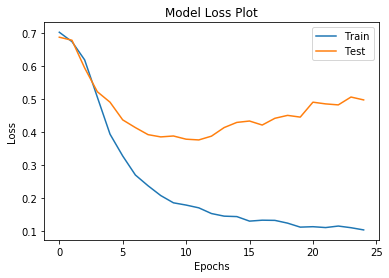

In [42]:
import matplotlib.pyplot as plt                             ###plot loss on train and val data
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Model Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'],loc = 'upper right')
plt.show()

In [45]:
model.save('cnn_model.hdf5')   ###save the model

In [32]:
from tensorflow.keras.models import load_model  ###load the model

In [94]:
model.load_weights('cnn_model.hdf5')

In [95]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [96]:
Y_pred=model.predict(X_test)
Y_pred =(Y_pred>0.5)

In [98]:
confusion = confusion_matrix(Y_test,Y_pred)        ###Model evaluation
precision = precision_score(Y_test,Y_pred)
recall = recall_score(Y_test,Y_pred)
F1 = f1_score(Y_test,Y_pred)
specificity = (confusion[0][0]/(confusion[0][0]+confusion[0][1]))
print('confusion matrix {}'.format(confusion))
print('precision is {}'.format(precision))
print('recall is  {}'.format(recall))
print('F1 score {}'.format(F1))
print('specificity is {}'.format(specificity))

confusion matrix [[302  40]
 [ 46 261]]
precision is 0.867109634551495
recall is  0.8501628664495114
F1 score 0.8585526315789473
specificity is 0.8830409356725146


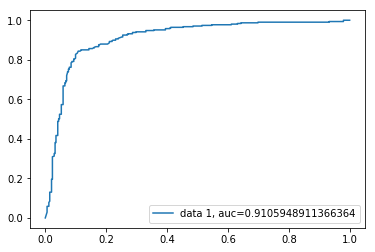

In [63]:
Y_pred_proba = model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
auc = roc_auc_score(Y_test, Y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# CNN MODEL - Case 2: Train model using pretrained embedding

In [65]:
embeddings = dict()                                 ##read glove vector file
f = open('../glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:],dtype='float32')
    embeddings[word]=vectors
f.close()

In [66]:
embedding_matrix = np.zeros((vocab_len, 100))      ###create a matrix consist of words and its vectors
for word, i in train_tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [37]:
model = Sequential()
e = Embedding(vocab_len, 100, input_length= 100, weights = [embedding_matrix], trainable = False)
model.add(e)
model.add(Conv1D(filters=256,kernel_size=5,activation='relu',strides= 1, kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units =128, activation= 'relu',kernel_initializer='he_uniform', kernel_constraint=maxnorm(4)))
model.add(Dropout(0.5))
model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))
model.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [31]:
cnn_pretrained_history=model.fit(X_train, Y_train, epochs = 25, batch_size = 128, verbose = 1, validation_split = 0.1)

Train on 2334 samples, validate on 260 samples
Epoch 1/25
2334/2334 [==============================] - 7s 3ms/step - loss: 0.6870 - acc: 0.5638 - val_loss: 0.6484 - val_acc: 0.6615
Epoch 2/25
2334/2334 [==============================] - 6s 2ms/step - loss: 0.6341 - acc: 0.6298 - val_loss: 0.6205 - val_acc: 0.6538
Epoch 3/25
2334/2334 [==============================] - 6s 3ms/step - loss: 0.5806 - acc: 0.6889 - val_loss: 0.5697 - val_acc: 0.7577
Epoch 4/25
2334/2334 [==============================] - 6s 3ms/step - loss: 0.5149 - acc: 0.7374 - val_loss: 0.5306 - val_acc: 0.7846
Epoch 5/25
2334/2334 [==============================] - 6s 3ms/step - loss: 0.4594 - acc: 0.7853 - val_loss: 0.4927 - val_acc: 0.7731
Epoch 6/25
2334/2334 [==============================] - 7s 3ms/step - loss: 0.4205 - acc: 0.8068 - val_loss: 0.4602 - val_acc: 0.8231
Epoch 7/25
2334/2334 [==============================] - 11s 5ms/step - loss: 0.3817 - acc: 0.8295 - val_loss: 0.4376 - val_acc: 0.8077
Epoch 8/25
233

In [32]:
score = model.evaluate(X_test,Y_test,verbose = 1)

649/649 [==============================] - 1s 788us/step


In [33]:
score[1]

0.8536209554077113

# Hyperparameter tuning

In [39]:
def model_cnn_create(neurons = 128, optimizer = 'Adam',
                 dropout_rate = 0.2, weight_constraint = 3, nb_filters = 256, kernel_size = 5):
    
    model = Sequential()
    e = Embedding(vocab_len, 100, input_length= 100, weights = [embedding_matrix], trainable = False)
    model.add(e)
    model.add(Conv1D(nb_filters, kernel_size, activation = 'relu',strides = 1, kernel_initializer= 'he_uniform'))   
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(units = neurons, kernel_constraint=maxnorm(weight_constraint),kernel_initializer= 'he_uniform', activation = 'relu'))
    model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))   
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [40]:
param_grid = {
    'optimizer': ['RMSprop','Adam','SGD'],

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

C:\Users\Dellpc\Anaconda2\envs\myenv\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] optimizer=RMSprop ...............................................
Epoch 1/10
 - 6s - loss: 0.6676 - acc: 0.6108
Epoch 2/10
 - 5s - loss: 0.4960 - acc: 0.7611
Epoch 3/10
 - 5s - loss: 0.3503 - acc: 0.8543
Epoch 4/10
 - 5s - loss: 0.2501 - acc: 0.8965
Epoch 5/10
 - 5s - loss: 0.1970 - acc: 0.9184
Epoch 6/10
 - 5s - loss: 0.1653 - acc: 0.9370
Epoch 7/10
 - 5s - loss: 0.1562 - acc: 0.9346
Epoch 8/10
 - 5s - loss: 0.1325 - acc: 0.9474
Epoch 9/10
 - 5s - loss: 0.1166 - acc: 0.9479
Epoch 10/10
 - 5s - loss: 0.1183 - acc: 0.9497
[CV] ................................ optimizer=RMSprop, total=  52.5s
[CV] optimizer=RMSprop ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.8s remaining:    0.0s


Epoch 1/10
 - 5s - loss: 0.6780 - acc: 0.6154
Epoch 2/10
 - 5s - loss: 0.5176 - acc: 0.7501
Epoch 3/10
 - 5s - loss: 0.3613 - acc: 0.8450
Epoch 4/10
 - 5s - loss: 0.2794 - acc: 0.8849
Epoch 5/10
 - 5s - loss: 0.2203 - acc: 0.9144
Epoch 6/10
 - 5s - loss: 0.1916 - acc: 0.9300
Epoch 7/10
 - 5s - loss: 0.1735 - acc: 0.9318
Epoch 8/10
 - 5s - loss: 0.1443 - acc: 0.9410
Epoch 9/10
 - 5s - loss: 0.1346 - acc: 0.9398
Epoch 10/10
 - 5s - loss: 0.1245 - acc: 0.9497
[CV] ................................ optimizer=RMSprop, total=  48.2s
[CV] optimizer=RMSprop ...............................................
Epoch 1/10
 - 5s - loss: 0.6809 - acc: 0.5919
Epoch 2/10
 - 5s - loss: 0.5224 - acc: 0.7197
Epoch 3/10
 - 5s - loss: 0.3685 - acc: 0.8370
Epoch 4/10
 - 5s - loss: 0.2621 - acc: 0.8815
Epoch 5/10
 - 5s - loss: 0.2317 - acc: 0.9035
Epoch 6/10
 - 5s - loss: 0.1780 - acc: 0.9277
Epoch 7/10
 - 5s - loss: 0.1728 - acc: 0.9295
Epoch 8/10
 - 5s - loss: 0.1468 - acc: 0.9358
Epoch 9/10
 - 5s - loss: 0.13

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  7.7min finished


Epoch 1/10
 - 10s - loss: 0.6517 - acc: 0.6176
Epoch 2/10
 - 8s - loss: 0.4719 - acc: 0.7726
Epoch 3/10
 - 8s - loss: 0.3027 - acc: 0.8755
Epoch 4/10
 - 7s - loss: 0.2253 - acc: 0.9090
Epoch 5/10
 - 8s - loss: 0.2035 - acc: 0.9167
Epoch 6/10
 - 8s - loss: 0.1742 - acc: 0.9283
Epoch 7/10
 - 8s - loss: 0.1517 - acc: 0.9368
Epoch 8/10
 - 7s - loss: 0.1325 - acc: 0.9464
Epoch 9/10
 - 8s - loss: 0.1250 - acc: 0.9460
Epoch 10/10
 - 7s - loss: 0.1163 - acc: 0.9507
Best accuracy:  0.7895142636854279
Best parameters:  {'optimizer': 'Adam'}


In [41]:
param_grid = {
    'neurons': [128,256]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

C:\Users\Dellpc\Anaconda2\envs\myenv\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] neurons=128 .....................................................
Epoch 1/10
 - 6s - loss: 0.6835 - acc: 0.5639
Epoch 2/10
 - 5s - loss: 0.5508 - acc: 0.7183
Epoch 3/10
 - 5s - loss: 0.4069 - acc: 0.8097
Epoch 4/10
 - 5s - loss: 0.2619 - acc: 0.8924
Epoch 5/10
 - 5s - loss: 0.2561 - acc: 0.8971
Epoch 6/10
 - 5s - loss: 0.1703 - acc: 0.9352
Epoch 7/10
 - 5s - loss: 0.1420 - acc: 0.9433
Epoch 8/10
 - 5s - loss: 0.1273 - acc: 0.9549
Epoch 9/10
 - 5s - loss: 0.1131 - acc: 0.9543
Epoch 10/10
 - 5s - loss: 0.1049 - acc: 0.9572
[CV] ...................................... neurons=128, total=  55.9s
[CV] neurons=128 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.3s remaining:    0.0s


Epoch 1/10
 - 7s - loss: 0.6628 - acc: 0.6084
Epoch 2/10
 - 5s - loss: 0.5009 - acc: 0.7455
Epoch 3/10
 - 5s - loss: 0.3554 - acc: 0.8392
Epoch 4/10
 - 5s - loss: 0.2808 - acc: 0.8791
Epoch 5/10
 - 5s - loss: 0.1823 - acc: 0.9346
Epoch 6/10
 - 5s - loss: 0.1598 - acc: 0.9375
Epoch 7/10
 - 5s - loss: 0.1400 - acc: 0.9416
Epoch 8/10
 - 5s - loss: 0.1236 - acc: 0.9485
Epoch 9/10
 - 5s - loss: 0.1178 - acc: 0.9514
Epoch 10/10
 - 5s - loss: 0.1190 - acc: 0.9497
[CV] ...................................... neurons=128, total=  54.5s
[CV] neurons=128 .....................................................
Epoch 1/10
 - 6s - loss: 0.6629 - acc: 0.5809
Epoch 2/10
 - 5s - loss: 0.5246 - acc: 0.7324
Epoch 3/10
 - 5s - loss: 0.3915 - acc: 0.8173
Epoch 4/10
 - 5s - loss: 0.2709 - acc: 0.8803
Epoch 5/10
 - 5s - loss: 0.2025 - acc: 0.9202
Epoch 6/10
 - 5s - loss: 0.1727 - acc: 0.9329
Epoch 7/10
 - 5s - loss: 0.2056 - acc: 0.9179
Epoch 8/10
 - 5s - loss: 0.1522 - acc: 0.9324
Epoch 9/10
 - 5s - loss: 0.12

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  6.8min finished


Epoch 1/10
 - 13s - loss: 0.6403 - acc: 0.6241
Epoch 2/10
 - 11s - loss: 0.4533 - acc: 0.7872
Epoch 3/10
 - 11s - loss: 0.2936 - acc: 0.8786
Epoch 4/10
 - 12s - loss: 0.2471 - acc: 0.9005
Epoch 5/10
 - 11s - loss: 0.1961 - acc: 0.9160
Epoch 6/10
 - 11s - loss: 0.1732 - acc: 0.9271
Epoch 7/10
 - 11s - loss: 0.1536 - acc: 0.9348
Epoch 8/10
 - 11s - loss: 0.1449 - acc: 0.9422
Epoch 9/10
 - 11s - loss: 0.1371 - acc: 0.9410
Epoch 10/10
 - 11s - loss: 0.1215 - acc: 0.9441
Best accuracy:  0.7887432536622976
Best parameters:  {'neurons': 256}


In [42]:
param_grid = {
    'nb_filters': [128,256],
    'kernel_size':[3,5]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

C:\Users\Dellpc\Anaconda2\envs\myenv\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] kernel_size=3, nb_filters=128 ...................................
Epoch 1/10
 - 4s - loss: 0.6622 - acc: 0.5969
Epoch 2/10
 - 2s - loss: 0.5548 - acc: 0.7195
Epoch 3/10
 - 2s - loss: 0.4576 - acc: 0.7843
Epoch 4/10
 - 2s - loss: 0.3413 - acc: 0.8531
Epoch 5/10
 - 2s - loss: 0.2622 - acc: 0.8976
Epoch 6/10
 - 2s - loss: 0.2606 - acc: 0.8942
Epoch 7/10
 - 2s - loss: 0.1775 - acc: 0.9387
Epoch 8/10
 - 3s - loss: 0.1788 - acc: 0.9294
Epoch 9/10
 - 2s - loss: 0.1316 - acc: 0.9456
Epoch 10/10
 - 3s - loss: 0.1148 - acc: 0.9578
[CV] .................... kernel_size=3, nb_filters=128, total=  28.2s
[CV] kernel_size=3, nb_filters=128 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.0s remaining:    0.0s


Epoch 1/10
 - 4s - loss: 0.6835 - acc: 0.5749
Epoch 2/10
 - 2s - loss: 0.5862 - acc: 0.6854
Epoch 3/10
 - 2s - loss: 0.4586 - acc: 0.7837
Epoch 4/10
 - 2s - loss: 0.3834 - acc: 0.8230
Epoch 5/10
 - 2s - loss: 0.2974 - acc: 0.8762
Epoch 6/10
 - 2s - loss: 0.2367 - acc: 0.9156
Epoch 7/10
 - 2s - loss: 0.1892 - acc: 0.9352
Epoch 8/10
 - 2s - loss: 0.1597 - acc: 0.9393
Epoch 9/10
 - 2s - loss: 0.1457 - acc: 0.9427
Epoch 10/10
 - 2s - loss: 0.1470 - acc: 0.9491
[CV] .................... kernel_size=3, nb_filters=128, total=  27.3s
[CV] kernel_size=3, nb_filters=128 ...................................
Epoch 1/10
 - 4s - loss: 0.6652 - acc: 0.5884
Epoch 2/10
 - 2s - loss: 0.5482 - acc: 0.7139
Epoch 3/10
 - 2s - loss: 0.4442 - acc: 0.7832
Epoch 4/10
 - 2s - loss: 0.3393 - acc: 0.8514
Epoch 5/10
 - 2s - loss: 0.2537 - acc: 0.8913
Epoch 6/10
 - 2s - loss: 0.2101 - acc: 0.9116
Epoch 7/10
 - 2s - loss: 0.1728 - acc: 0.9335
Epoch 8/10
 - 2s - loss: 0.1504 - acc: 0.9405
Epoch 9/10
 - 2s - loss: 0.14

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  8.6min finished


Epoch 1/10
 - 10s - loss: 0.6468 - acc: 0.6126
Epoch 2/10
 - 7s - loss: 0.4900 - acc: 0.7672
Epoch 3/10
 - 7s - loss: 0.3405 - acc: 0.8551
Epoch 4/10
 - 7s - loss: 0.2637 - acc: 0.8971
Epoch 5/10
 - 8s - loss: 0.2103 - acc: 0.9098
Epoch 6/10
 - 8s - loss: 0.1895 - acc: 0.9217
Epoch 7/10
 - 7s - loss: 0.1611 - acc: 0.9379
Epoch 8/10
 - 7s - loss: 0.1418 - acc: 0.9395
Epoch 9/10
 - 7s - loss: 0.1337 - acc: 0.9437
Epoch 10/10
 - 7s - loss: 0.1307 - acc: 0.9414
Best accuracy:  0.7941403238242097
Best parameters:  {'kernel_size': 3, 'nb_filters': 256}


In [44]:
param_grid = {
    'dropout_rate': [0.1,0.2,0.3,0.4,0.5]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

C:\Users\Dellpc\Anaconda2\envs\myenv\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] dropout_rate=0.1 ................................................
Epoch 1/10
 - 7s - loss: 0.6597 - acc: 0.6003
Epoch 2/10
 - 5s - loss: 0.4993 - acc: 0.7687
Epoch 3/10
 - 5s - loss: 0.3480 - acc: 0.8485
Epoch 4/10
 - 6s - loss: 0.2327 - acc: 0.9023
Epoch 5/10
 - 5s - loss: 0.1845 - acc: 0.9237
Epoch 6/10
 - 5s - loss: 0.1647 - acc: 0.9341
Epoch 7/10
 - 5s - loss: 0.1361 - acc: 0.9445
Epoch 8/10
 - 5s - loss: 0.1267 - acc: 0.9526
Epoch 9/10
 - 5s - loss: 0.1114 - acc: 0.9566
Epoch 10/10
 - 5s - loss: 0.1349 - acc: 0.9479
[CV] ................................. dropout_rate=0.1, total=  58.5s
[CV] dropout_rate=0.1 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   59.8s remaining:    0.0s


Epoch 1/10
 - 7s - loss: 0.6584 - acc: 0.5980
Epoch 2/10
 - 5s - loss: 0.5154 - acc: 0.7449
Epoch 3/10
 - 5s - loss: 0.3472 - acc: 0.8496
Epoch 4/10
 - 5s - loss: 0.2846 - acc: 0.8861
Epoch 5/10
 - 6s - loss: 0.1906 - acc: 0.9300
Epoch 6/10
 - 5s - loss: 0.1691 - acc: 0.9323
Epoch 7/10
 - 5s - loss: 0.1487 - acc: 0.9445
Epoch 8/10
 - 5s - loss: 0.1304 - acc: 0.9474
Epoch 9/10
 - 5s - loss: 0.1226 - acc: 0.9526
Epoch 10/10
 - 5s - loss: 0.1136 - acc: 0.9514
[CV] ................................. dropout_rate=0.1, total=  56.4s
[CV] dropout_rate=0.1 ................................................
Epoch 1/10
 - 7s - loss: 0.6505 - acc: 0.6081
Epoch 2/10
 - 5s - loss: 0.4968 - acc: 0.7566
Epoch 3/10
 - 5s - loss: 0.3511 - acc: 0.8428
Epoch 4/10
 - 5s - loss: 0.2431 - acc: 0.8960
Epoch 5/10
 - 5s - loss: 0.2004 - acc: 0.9173
Epoch 6/10
 - 5s - loss: 0.1828 - acc: 0.9254
Epoch 7/10
 - 5s - loss: 0.1408 - acc: 0.9422
Epoch 8/10
 - 5s - loss: 0.1402 - acc: 0.9399
Epoch 9/10
 - 5s - loss: 0.12

Epoch 9/10
 - 5s - loss: 0.1419 - acc: 0.9382
Epoch 10/10
 - 5s - loss: 0.1248 - acc: 0.9468
[CV] ................................. dropout_rate=0.5, total=  58.4s


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 15.1min finished


Epoch 1/10
 - 10s - loss: 0.6475 - acc: 0.6218
Epoch 2/10
 - 8s - loss: 0.4770 - acc: 0.7652
Epoch 3/10
 - 8s - loss: 0.3174 - acc: 0.8601
Epoch 4/10
 - 8s - loss: 0.2241 - acc: 0.9048
Epoch 5/10
 - 9s - loss: 0.1968 - acc: 0.9175
Epoch 6/10
 - 8s - loss: 0.1782 - acc: 0.9325
Epoch 7/10
 - 8s - loss: 0.1488 - acc: 0.9372
Epoch 8/10
 - 9s - loss: 0.1362 - acc: 0.9441
Epoch 9/10
 - 8s - loss: 0.1271 - acc: 0.9449
Epoch 10/10
 - 8s - loss: 0.1578 - acc: 0.9341
Best accuracy:  0.7960678488820354
Best parameters:  {'dropout_rate': 0.5}


In [46]:
param_grid = {
    'weight_constraint': [1,2,3,4,5]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

C:\Users\Dellpc\Anaconda2\envs\myenv\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] weight_constraint=1 .............................................
Epoch 1/10
 - 8s - loss: 0.6694 - acc: 0.5917
Epoch 2/10
 - 5s - loss: 0.5433 - acc: 0.7230
Epoch 3/10
 - 5s - loss: 0.3922 - acc: 0.8300
Epoch 4/10
 - 5s - loss: 0.2893 - acc: 0.8890
Epoch 5/10
 - 5s - loss: 0.2082 - acc: 0.9144
Epoch 6/10
 - 5s - loss: 0.1838 - acc: 0.9289
Epoch 7/10
 - 5s - loss: 0.1532 - acc: 0.9416
Epoch 8/10
 - 5s - loss: 0.1425 - acc: 0.9433
Epoch 9/10
 - 5s - loss: 0.1281 - acc: 0.9474
Epoch 10/10
 - 5s - loss: 0.1186 - acc: 0.9537
[CV] .............................. weight_constraint=1, total= 1.0min
[CV] weight_constraint=1 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


Epoch 1/10
 - 8s - loss: 0.6737 - acc: 0.5963
Epoch 2/10
 - 5s - loss: 0.5458 - acc: 0.7287
Epoch 3/10
 - 5s - loss: 0.3949 - acc: 0.8300
Epoch 4/10
 - 5s - loss: 0.2685 - acc: 0.8843
Epoch 5/10
 - 5s - loss: 0.2111 - acc: 0.9167
Epoch 6/10
 - 5s - loss: 0.1572 - acc: 0.9387
Epoch 7/10
 - 5s - loss: 0.1418 - acc: 0.9503
Epoch 8/10
 - 5s - loss: 0.1281 - acc: 0.9532
Epoch 9/10
 - 5s - loss: 0.1224 - acc: 0.9503
Epoch 10/10
 - 5s - loss: 0.1074 - acc: 0.9595
[CV] .............................. weight_constraint=1, total=  59.5s
[CV] weight_constraint=1 .............................................
Epoch 1/10
 - 8s - loss: 0.6581 - acc: 0.6029
Epoch 2/10
 - 6s - loss: 0.4981 - acc: 0.7480
Epoch 3/10
 - 5s - loss: 0.3529 - acc: 0.8405
Epoch 4/10
 - 5s - loss: 0.2373 - acc: 0.9012
Epoch 5/10
 - 5s - loss: 0.2188 - acc: 0.9197
Epoch 6/10
 - 5s - loss: 0.1713 - acc: 0.9312
Epoch 7/10
 - 5s - loss: 0.1925 - acc: 0.9249
Epoch 8/10
 - 5s - loss: 0.1547 - acc: 0.9358
Epoch 9/10
 - 5s - loss: 0.18

Epoch 9/10
 - 6s - loss: 0.1350 - acc: 0.9445
Epoch 10/10
 - 5s - loss: 0.1266 - acc: 0.9416
[CV] .............................. weight_constraint=5, total= 1.1min


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 15.7min finished


Epoch 1/10
 - 11s - loss: 0.6476 - acc: 0.6226
Epoch 2/10
 - 8s - loss: 0.4883 - acc: 0.7544
Epoch 3/10
 - 9s - loss: 0.3417 - acc: 0.8489
Epoch 4/10
 - 9s - loss: 0.2440 - acc: 0.8975
Epoch 5/10
 - 9s - loss: 0.2043 - acc: 0.9252
Epoch 6/10
 - 9s - loss: 0.1733 - acc: 0.9268
Epoch 7/10
 - 8s - loss: 0.1621 - acc: 0.9360
Epoch 8/10
 - 8s - loss: 0.1444 - acc: 0.9402
Epoch 9/10
 - 9s - loss: 0.1450 - acc: 0.9399
Epoch 10/10
 - 8s - loss: 0.1349 - acc: 0.9414
Best accuracy:  0.7910562837316885
Best parameters:  {'weight_constraint': 1}


In [47]:
param_grid = {
    'batch_size': [32,64,128,256]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

C:\Users\Dellpc\Anaconda2\envs\myenv\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] batch_size=32 ...................................................
Epoch 1/10
 - 9s - loss: 0.6815 - acc: 0.5772
Epoch 2/10
 - 5s - loss: 0.5607 - acc: 0.7079
Epoch 3/10
 - 5s - loss: 0.4043 - acc: 0.8126
Epoch 4/10
 - 5s - loss: 0.2983 - acc: 0.8791
Epoch 5/10
 - 5s - loss: 0.2232 - acc: 0.9121
Epoch 6/10
 - 5s - loss: 0.1896 - acc: 0.9283
Epoch 7/10
 - 5s - loss: 0.1592 - acc: 0.9410
Epoch 8/10
 - 5s - loss: 0.1486 - acc: 0.9479
Epoch 9/10
 - 5s - loss: 0.1324 - acc: 0.9479
Epoch 10/10
 - 5s - loss: 0.1206 - acc: 0.9543
[CV] .................................... batch_size=32, total= 1.0min
[CV] batch_size=32 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


Epoch 1/10
 - 9s - loss: 0.6678 - acc: 0.5940
Epoch 2/10
 - 6s - loss: 0.5080 - acc: 0.7525
Epoch 3/10
 - 6s - loss: 0.3412 - acc: 0.8462
Epoch 4/10
 - 6s - loss: 0.2786 - acc: 0.8826
Epoch 5/10
 - 5s - loss: 0.1812 - acc: 0.9335
Epoch 6/10
 - 5s - loss: 0.1543 - acc: 0.9404
Epoch 7/10
 - 5s - loss: 0.1320 - acc: 0.9485
Epoch 8/10
 - 5s - loss: 0.1476 - acc: 0.9433
Epoch 9/10
 - 5s - loss: 0.1226 - acc: 0.9514
Epoch 10/10
 - 5s - loss: 0.1070 - acc: 0.9566
[CV] .................................... batch_size=32, total= 1.0min
[CV] batch_size=32 ...................................................
Epoch 1/10
 - 8s - loss: 0.6464 - acc: 0.6145
Epoch 2/10
 - 5s - loss: 0.4932 - acc: 0.7566
Epoch 3/10
 - 5s - loss: 0.3442 - acc: 0.8462
Epoch 4/10
 - 5s - loss: 0.2523 - acc: 0.8983
Epoch 5/10
 - 5s - loss: 0.2084 - acc: 0.9069
Epoch 6/10
 - 5s - loss: 0.1705 - acc: 0.9260
Epoch 7/10
 - 5s - loss: 0.1540 - acc: 0.9341
Epoch 8/10
 - 5s - loss: 0.1518 - acc: 0.9353
Epoch 9/10
 - 5s - loss: 0.13

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 11.3min finished


Epoch 1/10
 - 12s - loss: 0.6608 - acc: 0.5948
Epoch 2/10
 - 9s - loss: 0.4935 - acc: 0.7687
Epoch 3/10
 - 9s - loss: 0.3399 - acc: 0.8531
Epoch 4/10
 - 9s - loss: 0.2376 - acc: 0.9071
Epoch 5/10
 - 9s - loss: 0.1950 - acc: 0.9217
Epoch 6/10
 - 9s - loss: 0.1690 - acc: 0.9372
Epoch 7/10
 - 9s - loss: 0.1557 - acc: 0.9360
Epoch 8/10
 - 9s - loss: 0.1457 - acc: 0.9372
Epoch 9/10
 - 9s - loss: 0.1309 - acc: 0.9445
Epoch 10/10
 - 8s - loss: 0.1278 - acc: 0.9460
Best accuracy:  0.792212798766384
Best parameters:  {'batch_size': 32}


# CNN-Pretrained Embedding MODEL WITH OPTIMISED PARAMETERS

In [99]:
model = Sequential()
e = Embedding(vocab_len, 100, input_length= 100, weights = [embedding_matrix], trainable = False)
model.add(e)
model.add(Conv1D(filters=256,kernel_size=3,activation='relu',strides= 1, kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units =256, activation= 'relu',kernel_initializer='he_uniform', kernel_constraint=maxnorm(1)))
model.add(Dropout(0.5))
model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))
model.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [52]:
cnn_pretrained_history=model.fit(X_train, Y_train, epochs = 25, batch_size = 32, verbose = 1, validation_split = 0.1)

Train on 2334 samples, validate on 260 samples
Epoch 1/25
2334/2334 [==============================] - 17s 7ms/step - loss: 0.6820 - acc: 0.5771 - val_loss: 0.6272 - val_acc: 0.6692
Epoch 2/25
2334/2334 [==============================] - 12s 5ms/step - loss: 0.5779 - acc: 0.6915 - val_loss: 0.5580 - val_acc: 0.7000
Epoch 3/25
2334/2334 [==============================] - 11s 5ms/step - loss: 0.5019 - acc: 0.7532 - val_loss: 0.5387 - val_acc: 0.7077
Epoch 4/25
2334/2334 [==============================] - 12s 5ms/step - loss: 0.4473 - acc: 0.7858 - val_loss: 0.4820 - val_acc: 0.7423
Epoch 5/25
2334/2334 [==============================] - 11s 5ms/step - loss: 0.3894 - acc: 0.8179 - val_loss: 0.4384 - val_acc: 0.8038
Epoch 6/25
2334/2334 [==============================] - 13s 5ms/step - loss: 0.3619 - acc: 0.8462 - val_loss: 0.4126 - val_acc: 0.7923
Epoch 7/25
2334/2334 [==============================] - 12s 5ms/step - loss: 0.3180 - acc: 0.8590 - val_loss: 0.4203 - val_acc: 0.8231
Epoch 8/

In [53]:
score = model.evaluate(X_test,Y_test,verbose = 1)
score[1]

649/649 [==============================] - 0s 738us/step


0.8705701079500842

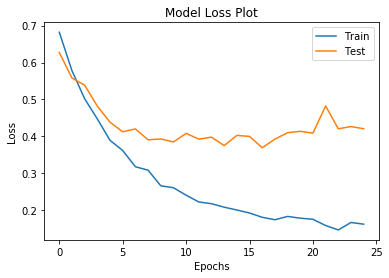

In [55]:
import matplotlib.pyplot as plt                             ###plot loss on train and val data
plt.plot(cnn_pretrained_history.history['loss'])
plt.plot(cnn_pretrained_history.history['val_loss'])
plt.title('Model Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'],loc = 'upper right')
plt.show()

In [56]:
model.save('cnn_pretrained_model.hdf5')

In [100]:
model.load_weights('cnn_pretrained_model.hdf5')

In [101]:
Y_pred = model.predict(X_test)
Y_pred = (Y_pred >0.5)

In [102]:
confusion = confusion_matrix(Y_test,Y_pred)        ###Model evaluation
precision = precision_score(Y_test,Y_pred)
recall = recall_score(Y_test,Y_pred)
F1 = f1_score(Y_test,Y_pred)
specificity = (confusion[0][0]/(confusion[0][0]+confusion[0][1]))
print('confusion matrix {}'.format(confusion))
print('precision is {}'.format(precision))
print('recall is  {}'.format(recall))
print('F1 score {}'.format(F1))
print('specificity is {}'.format(specificity))

confusion matrix [[301  41]
 [ 43 264]]
precision is 0.8655737704918033
recall is  0.8599348534201955
F1 score 0.8627450980392157
specificity is 0.8801169590643275


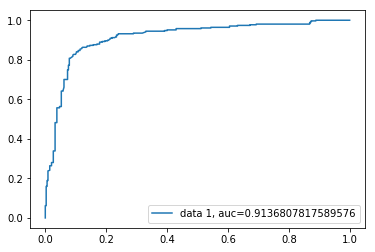

In [71]:
Y_pred_proba = model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
auc = roc_auc_score(Y_test, Y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()